In [178]:
from qiskit import *
from numpy import pi
circuit = QuantumCircuit(3,3)
# QUBIT ORDERING
# q0 = State |psi> that we want to teleport
# q1 = Alice's half of the Bell pair
# q2 = Bob's half of the Bell pair, the destination of the teleportation

# ========================
# Step 0: Create the state to be teleported in qubit 0
circuit.x(0) # qubit 0 is now in state |1>, and this is the state that we want to teleport

circuit.barrier() # just a visual aid

# ========================
# Step 1: create an entangled Bell pair between Alice and Bob (qubits 1 and 2)
circuit.h(1)
circuit.cx(1,2)

circuit.barrier() # just a visual aid

# ========================
# Step 2: Alice applies a series of operations 
# between the state to teleport (qubit 0) and her half of the Bell pair (qubit 1)
circuit.cx(0,1)
circuit.h(0)

circuit.barrier() # just a visual aid

# ========================
# Step 3: Alice measures both qubits 0 and 1
circuit.measure([0, 1], [0, 1]) # results stored in classical bits 0 and 1, respectively

circuit.barrier() # just a visual aid

# ========================
# Step 4: Now that Alice has measured the two qubits, their states have collapsed to 0 and 1. 
# Bob can do operations conditioned on these qubits to his half of the Bell pair
# Note that while we're conditioning Bob's operation on the collapsed qubits 0 and 1, we can
# do teleportation over long distances by transmitting the classical information in classical bits 0 and 1
circuit.cx(1, 2)
circuit.cz(0, 2)

# Step 5: Done! Measure Bob's qubit to find out what state it is in
circuit.measure([2], [2])

In [179]:
%matplotlib inline
circuit.draw()

┌───┐ ░            ░      ┌───┐ ░ ┌─┐    ░            
q_0: ┤ X ├─░────────────░───■──┤ H ├─░─┤M├────░───────■────
     └───┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░       │    
q_1: ──────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───■───┼────
           ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░ ┌─┴─┐ │ ┌─┐
q_2: ──────░──────┤ X ├─░────────────░──╫──╫──░─┤ X ├─■─┤M├
           ░      └───┘ ░            ░  ║  ║  ░ └───┘   └╥┘
c: 3/═══════════════════════════════════╩══╩═════════════╩═
                                        0  1             2

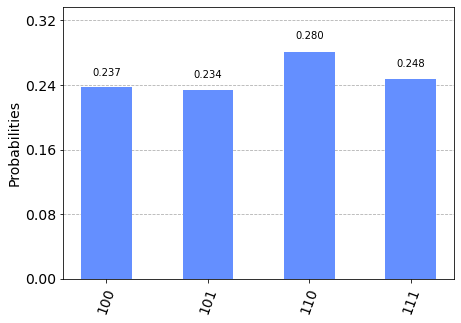

In [180]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

In [181]:
def create_state_psi(theta):
    # Create a state along the x axis on the x-y plane and then rotate it by angle theta around the z-axis
    # theta = 0 => state is exactly along x
    # theta = pi/2 => state is exactly along y
    create_circuit = QuantumCircuit(1, name='create_state_psi')
    create_circuit.h(0)
    create_circuit.rz(theta, 0)
    return create_circuit

def create_Bell_pair():
    create_Bell_circuit = QuantumCircuit(2, name='create_Bell_pair')
    create_Bell_circuit.h(0)
    create_Bell_circuit.cx(0,1)
    return create_Bell_circuit

def teleportation_Alice():
    teleportation_Alice_circuit = QuantumCircuit(2, name='teleportation_Alice')
    teleportation_Alice_circuit.cx(0,1)
    teleportation_Alice_circuit.h(0)
    return teleportation_Alice_circuit

def Alice_measure():
    Alice_measure_circuit = QuantumCircuit(2, 2, name='Alice_measure')
    Alice_measure_circuit.measure([0,1], [0,1])
    return Alice_measure_circuit

def teleportation_Bob():
    teleportation_Bob_circuit = QuantumCircuit(3, name='teleportation_Bob')
    teleportation_Bob_circuit.cx(1,2)
    teleportation_Bob_circuit.cz(0,2)
    return teleportation_Bob_circuit

def build_circuit(theta):
    circuit = QuantumCircuit(3, 3)
    # Step 0: create the state to teleport
    circuit.append(create_state_psi(theta).to_instruction(), [0])
    circuit.barrier()
    # Step 1: create the Bell pair between Alice and Bob's qubits
    circuit.append(create_Bell_pair().to_instruction(), [1,2])
    circuit.barrier()
    # Step 2: Alice applies a series of operations
    circuit.append(teleportation_Alice().to_instruction(), [0,1])
    circuit.barrier()
    # Step 3: Alice measures her two qubits
    circuit.append(Alice_measure().to_instruction(), [0,1], [0,1])
    circuit.barrier()
    # Step 4: Bob applies operations to his qubit depending on Alice's measurement outcomes
    circuit.append(teleportation_Bob().to_instruction(), [0,1,2])
    circuit.barrier()
    # Step 5: Done. Now measure Bob's qubit to be sure that teleportation was successful
    circuit.h(2) # note that the Hadamard gate here ensures that we measure in the Hadamard basis instead of z basis
    circuit.measure([0,1,2], [0,1,2])
    return circuit

circuit = build_circuit(0.01)
circuit.draw()

C:\Users\igor_\anaconda3\lib\site-packages\qiskit\visualization\text.py:659: RuntimeWarning: The parameter "cregbundle" was disabled, since an instruction needs to refer to individual classical wires
  return "\n".join(self.lines()).encode(self.encoding).decode(self.encoding)


┌──────────────────┐ ░                       ░ ┌──────────────────────┐ ░ »
q_0: ┤ create_state_psi ├─░───────────────────────░─┤0                     ├─░─»
     └──────────────────┘ ░ ┌───────────────────┐ ░ │  teleportation_Alice │ ░ »
q_1: ─────────────────────░─┤0                  ├─░─┤1                     ├─░─»
                          ░ │  create_Bell_pair │ ░ └──────────────────────┘ ░ »
q_2: ─────────────────────░─┤1                  ├─░──────────────────────────░─»
                          ░ └───────────────────┘ ░                          ░ »
c_0: ══════════════════════════════════════════════════════════════════════════»
                                                                               »
c_1: ══════════════════════════════════════════════════════════════════════════»
                                                                               »
c_2: ══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌────────────────┐ ░ ┌────────────────────┐ ░      ┌─┐      
«q_0: ┤0               ├─░─┤0                   ├─░──────┤M├──────
«     │                │ ░ │                    │ ░      └╥┘┌─┐   
«q_1: ┤1               ├─░─┤1 teleportation_Bob ├─░───────╫─┤M├───
«     │                │ ░ │                    │ ░ ┌───┐ ║ └╥┘┌─┐
«q_2: ┤  Alice_measure ├─░─┤2                   ├─░─┤ H ├─╫──╫─┤M├
«     │                │ ░ └────────────────────┘ ░ └───┘ ║  ║ └╥┘
«c_0: ╡0               ╞══════════════════════════════════╩══╬══╬═
«     │                │                                     ║  ║ 
«c_1: ╡1               ╞═════════════════════════════════════╩══╬═
«     └────────────────┘                                        ║ 
«c_2: ══════════════════════════════════════════════════════════╩═
«

In [182]:
circuit.decompose().draw()

┌───┐┌──────────┐ ░            ░      ┌───┐ ░ ┌─┐    ░          ░ ┌─┐   »
q_0: ┤ H ├┤ Rz(0.01) ├─░────────────░───■──┤ H ├─░─┤M├────░───────■──░─┤M├───»
     └───┘└──────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░       │  ░ └╥┘┌─┐»
q_1: ──────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───■───┼──░──╫─┤M├»
                       ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░ ┌─┴─┐ │  ░  ║ └╥┘»
q_2: ──────────────────░──────┤ X ├─░────────────░──╫──╫──░─┤ X ├─■──░──╫──╫─»
                       ░      └───┘ ░            ░  ║  ║  ░ └───┘    ░  ║  ║ »
c: 3/═══════════════════════════════════════════════╩══╩════════════════╩══╩═»
                                                    0  1                0  1 »
«                   
«q_0: ──────────────
«                   
«q_1: ──────────────
«     ┌─────────┐┌─┐
«q_2: ┤ U2(0,π) ├┤M├
«     └─────────┘└╥┘
«c: 3/════════════╩═
«                 2

In [183]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
counts = result.get_counts(circuit)
print(counts)
num_c2_zero = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '0')

{'011': 242, '000': 259, '010': 272, '001': 251}


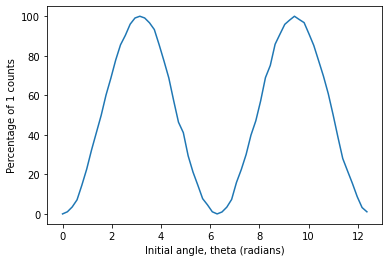

In [184]:
import numpy as np
thetas = np.arange(0, 4*np.pi, np.pi/16)

simulator = Aer.get_backend('qasm_simulator')

percent_ones = []

for theta in thetas:
    circuit = build_circuit(theta)
    result = execute(circuit, backend=simulator, shots=1024).result()
    counts = result.get_counts(circuit)
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./1024)
    
import matplotlib.pyplot as plotter
plotter.plot(thetas, percent_ones)
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.show()

In [196]:
# build circuits
thetas = np.arange(0, 4*np.pi, np.pi/16)

circuits = []
for theta in thetas:
    circuit = build_circuit(theta)
    circuits.append(circuit)

In [197]:
IBMQ.save_account('5e5a282c7335080696213400d67343226dfc504a12bc208d2fdb6d0021666f01567321c818b5df5bab17eb4319d8a89ba5c93f6d6e547f8f2835515b94df058e',overwrite=True)

In [201]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
Qcomp = provider.get_backend('ibmq_lima')


job = execute(circuits, backend=Qcomp, shots=512, int=[6,8,7])
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

ibmqfactory.load_account:WARNING:2021-10-18 23:34:21,521: Credentials are already in use. The existing account in the session will be replaced.
C:\Users\igor_\anaconda3\lib\site-packages\qiskit\execute_function.py:399: UserWarning: int is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


616e2eb4bf409efa4ca4a717
Job Status: job has successfully run


In [202]:
simresult = execute(circuits, backend=simulator, shots=512).result()

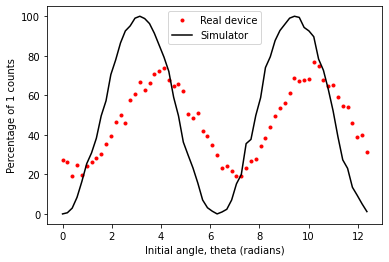

In [204]:
result = job.result()

percent_ones = []
for circuit in circuits:
    thiscircuit_counts = result.get_counts(circuit)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./512)
    
percent_ones_sim = []
for circuit in circuits:
    thiscircuit_counts = simresult.get_counts(circuit)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones*100./512)
    

plotter.plot(thetas, percent_ones, 'r.', label='Real device')
plotter.plot(thetas, percent_ones_sim, 'k', label='Simulator')
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.legend()
plotter.show()

In [205]:
thetas = np.arange(0, 4*np.pi, np.pi/16)
circuits_classicalcontrol = []
for theta in thetas:
    cr1 = ClassicalRegister(1)
    cr2 = ClassicalRegister(1)
    cr3 = ClassicalRegister(1)
    qr = QuantumRegister(3)
    circuit = QuantumCircuit(qr, cr1, cr2, cr3)

    # ========================
    # Step 0: Create the state to be teleported in qubit 0
    circuit.h(0)
    circuit.rz(theta, 0)
    circuit.barrier()
    # ========================
    # Step 1: create an entangled Bell pair between Alice and Bob (qubits 1 and 2)
    circuit.h(1)
    circuit.cx(1,2)
    circuit.barrier()
    # ========================
    # Step 2: Alice applies a series of operations 
    # between the state to teleport (qubit 0) and her half of the Bell pair (qubit 1)
    circuit.cx(0,1)
    circuit.h(0)
    circuit.barrier()
    # ========================
    # Step 3: Alice measures both qubits 0 and 1
    circuit.measure([0, 1], [0, 1]) # results stored in classical bits 0 and 1, respectively
    circuit.barrier()
    # ========================
    # Step 4: Now that Alice has measured the two qubits, their states have collapsed to 0 and 1. 
    # Use the classical bits from Alice's measurements to do operations on Bob's half of the Bell pair
    circuit.x(2).c_if(cr2, 1)
    circuit.z(2).c_if(cr1, 1)
    circuit.barrier()
    # Step 5: Done! Measure Bob's qubit in the Hadamard basis to find out what state it is in
    circuit.h(2)
    circuit.measure([2], [2])
    
    circuits_classicalcontrol.append(circuit)
    
circuits_classicalcontrol[0].draw()

┌───┐┌───────┐ ░            ░      ┌───┐ ░ ┌─┐    ░                ░ »
q39344_0: ┤ H ├┤ Rz(0) ├─░────────────░───■──┤ H ├─░─┤M├────░────────────────░─»
          └───┘└───────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                ░ »
q39344_1: ───────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░────────────────░─»
                         ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐  ░ »
q39344_2: ───────────────░──────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├──░─»
                         ░      └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘  ░ »
                                                      ║  ║       ║   ┌──╨──┐   »
    c0: 1/════════════════════════════════════════════╩══╬═══════╬═══╡ = 1 ╞═══»
                                                      0  ║    ┌──╨──┐└─────┘   »
    c1: 1/═══════════════════════════════════════════════╩════╡ = 1 ╞══════════»
                                                         0    └─────┘          »
    c2: 1/═════════════════════════════════════════════════════════════════════»
                                                                               »
«                  
«q39344_0: ────────
«                  
«q39344_1: ────────
«          ┌───┐┌─┐
«q39344_2: ┤ H ├┤M├
«          └───┘└╥┘
«    c0: 1/══════╬═
«                ║ 
«    c1: 1/══════╬═
«                ║ 
«    c2: 1/══════╩═
«                0

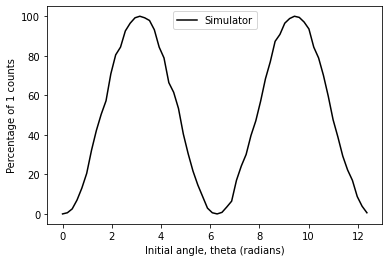

In [206]:

simulator = Aer.get_backend('qasm_simulator')
simresult_classicalcontrol = execute(circuits_classicalcontrol, backend=simulator, shots=512).result()

percent_ones_sim = []
for ii in range(len((circuits))):
    thiscircuit_counts = simresult_classicalcontrol.get_counts(ii)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones*100./512)
    
plotter.plot(thetas, percent_ones_sim, 'k', label='Simulator')
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.legend()
plotter.show()